In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок
from sklearn.linear_model import SGDRegressor, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pickle
import mlflow
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlflow.models import infer_signature
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('dataset.xls')# Датасет по популярности треков Spotify
df.info()#Информация по колонкам датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [3]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
#Избавимся от object и нормализуем данные
df=df.dropna()
df['duration_minutes'] = df['duration_ms'] / 1000 / 60
df = df.drop(columns=['Unnamed: 0'])
df= df.select_dtypes(exclude=['object'])
df[df.select_dtypes(include=['bool']).columns] = df.select_dtypes(include=['bool']).astype(int)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        113999 non-null  int64  
 1   duration_ms       113999 non-null  int64  
 2   explicit          113999 non-null  int32  
 3   danceability      113999 non-null  float64
 4   energy            113999 non-null  float64
 5   key               113999 non-null  int64  
 6   loudness          113999 non-null  float64
 7   mode              113999 non-null  int64  
 8   speechiness       113999 non-null  float64
 9   acousticness      113999 non-null  float64
 10  instrumentalness  113999 non-null  float64
 11  liveness          113999 non-null  float64
 12  valence           113999 non-null  float64
 13  tempo             113999 non-null  float64
 14  time_signature    113999 non-null  int64  
 15  duration_minutes  113999 non-null  float64
dtypes: float64(10), int32(1),

In [6]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Разделение данных
X = df.drop(columns=['popularity'])  # Фича-инжениринг: убираем целевую переменную
y = df['popularity'].values.reshape(-1, 1)

X = X.astype(float)

scaler = StandardScaler()

# Масштабирование признаков
X_scaled = scaler.fit_transform(X)

# Масштабирование целевой переменной
y_scaled = scaler.fit_transform(y)

# Разделение на тренировочную и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


In [8]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

## Обучение моделей

In [9]:
#SGDRegressor
#Параметры для GridSearch
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
          'l1_ratio': [0.001, 0.05, 0.01, 0.2]}

mlflow.set_experiment('Spotify')

with mlflow.start_run(run_name="GridSearch"):
    # Создаём модель
    lr = SGDRegressor(random_state=42)
    clf = GridSearchCV(lr, params, cv=5)
    clf.fit(X_train, y_train.ravel())
    
    best = clf.best_estimator_
    y_pred = best.predict(X_val)
    y_price_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    
    rmse, mae, r2 = eval_metrics(scaler.inverse_transform(y_val), y_price_pred)
    
    mlflow.log_param("alpha", best.alpha)
    mlflow.log_param("l1_ratio", best.l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    predictions = best.predict(X_train)
    signature = infer_signature(X_train, predictions)
    mlflow.sklearn.log_model(best, "model", signature=signature)

In [10]:
# Обучение Ridge
with mlflow.start_run(run_name="Ridge") as run:
    ridge = Ridge(random_state=42)
    ridge.fit(X_train, y_train.ravel())
    y_pred = ridge.predict(X_val)
    y_price_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    rmse, mae, r2 = eval_metrics(scaler.inverse_transform(y_val), y_price_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(ridge, "model",signature=signature)

In [11]:
# Обучение Lasso с подбором параметров
with mlflow.start_run(run_name="Lasso") as run:
    lasso = Lasso(random_state=42)
    clf = GridSearchCV(lasso, {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1]}, cv=5)
    clf.fit(X_train, y_train.ravel())
    best_lasso = clf.best_estimator_
    y_pred = best_lasso.predict(X_val)
    y_price_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    rmse, mae, r2 = eval_metrics(scaler.inverse_transform(y_val), y_price_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(best_lasso, "model",signature=signature)

In [12]:
# Обучение RandomForest
from sklearn.ensemble import RandomForestRegressor
with mlflow.start_run(run_name="RandomForest") as run:
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train.ravel())
    y_pred = rf.predict(X_val)
    y_price_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    rmse, mae, r2 = eval_metrics(scaler.inverse_transform(y_val), y_price_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(rf, "model",signature=signature)

In [13]:
# Обучение GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
with mlflow.start_run(run_name="GradientBoosting") as run:
    gb = GradientBoostingRegressor(random_state=42)
    gb.fit(X_train, y_train.ravel())
    y_pred = gb.predict(X_val)
    y_price_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    rmse, mae, r2 = eval_metrics(scaler.inverse_transform(y_val), y_price_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(gb, "model",signature=signature)

## Графики

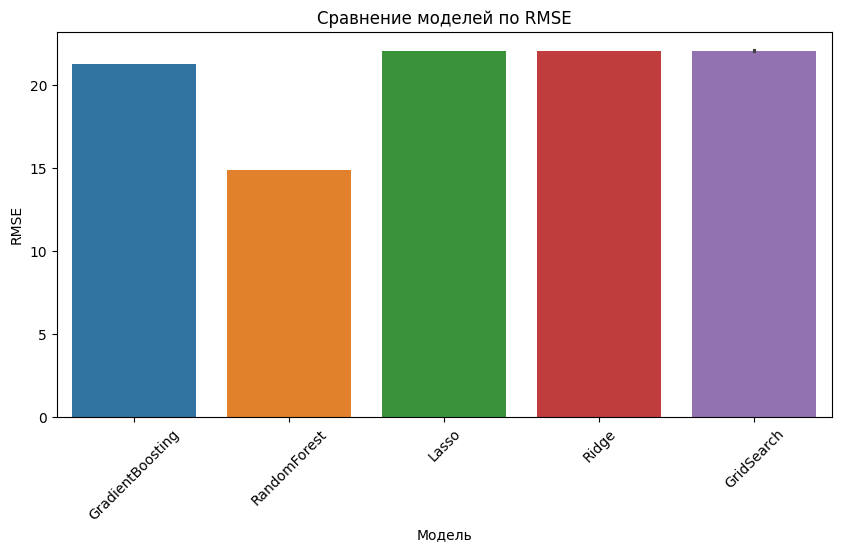

In [14]:
import seaborn as sns
experiment = mlflow.get_experiment_by_name('Spotify')
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

results_df = runs[['tags.mlflow.runName', 'metrics.rmse', 'metrics.r2', 'metrics.mae']]
results_df = results_df.rename(columns={'tags.mlflow.runName': 'Model'})

# Исключаем модели с высокой ошибкой
results_df = results_df[results_df['metrics.rmse'] < 50]

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='metrics.rmse', hue='Model', data=results_df, legend=False)
plt.title("Сравнение моделей по RMSE")
plt.ylabel("RMSE")
plt.xlabel("Модель")
plt.xticks(rotation=45)
plt.show()


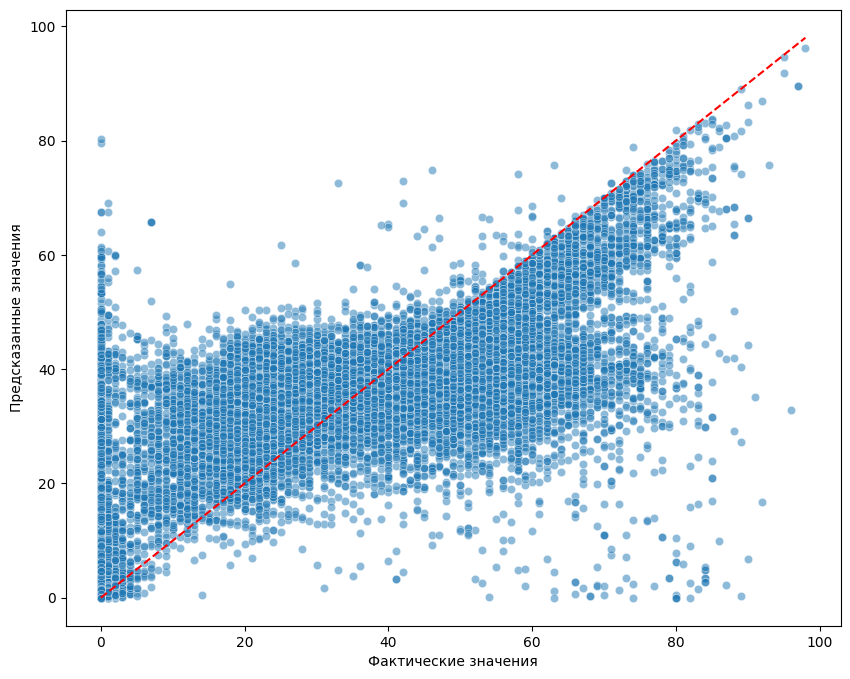

In [15]:
# Визуализация предсказаний vs. фактических значений для RandomForest
rf_run = runs[runs['tags.mlflow.runName'] == 'RandomForest'].iloc[0]
rf_model = mlflow.sklearn.load_model(f"runs:/{rf_run.run_id}/model")
rf_predictions = rf_model.predict(X_val)
y_val_actual = scaler.inverse_transform(y_val)#Инвертируем в исходный вид
y_val_pred = scaler.inverse_transform(rf_predictions.reshape(-1, 1))

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_val_actual.flatten(), y=y_val_pred.flatten(), alpha=0.5)#По оси х-реальное, по y-предсказанное
plt.plot([y_val_actual.min(), y_val_actual.max()], [y_val_actual.min(), y_val_actual.max()], 'r', linestyle='--')#Если точки на этой линии, значит угадали
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.show()

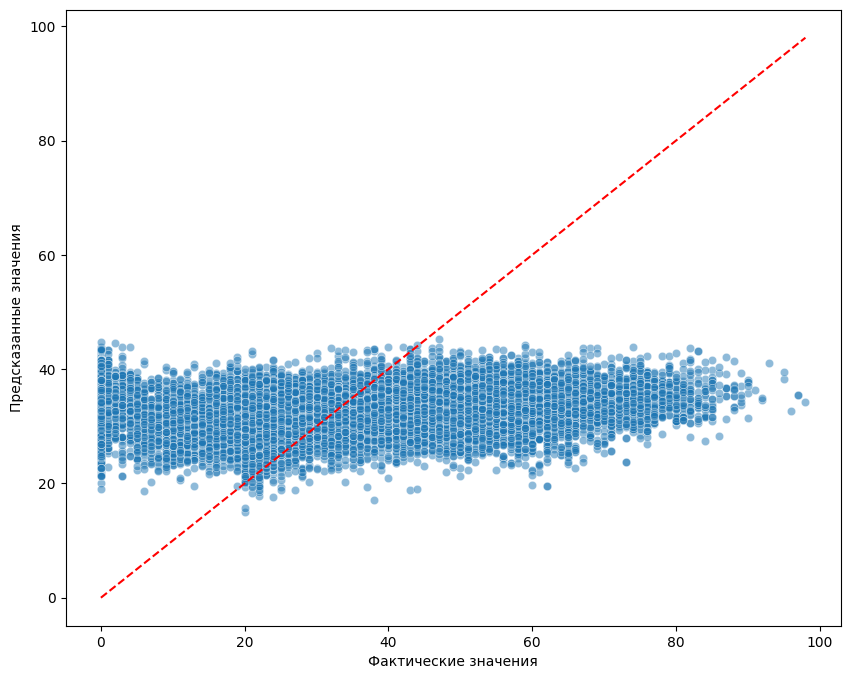

In [16]:
rf_run = runs[runs['tags.mlflow.runName'] == 'Lasso'].iloc[0]
rf_model = mlflow.sklearn.load_model(f"runs:/{rf_run.run_id}/model")
rf_predictions = rf_model.predict(X_val)
y_val_actual = scaler.inverse_transform(y_val)#Инвертируем в исходный вид
y_val_pred = scaler.inverse_transform(rf_predictions.reshape(-1, 1))

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_val_actual.flatten(), y=y_val_pred.flatten(), alpha=0.5)#По оси х-реальное, по y-предсказанное
plt.plot([y_val_actual.min(), y_val_actual.max()], [y_val_actual.min(), y_val_actual.max()], 'r', linestyle='--')#Если точки на этой линии, значит угадали
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.show()

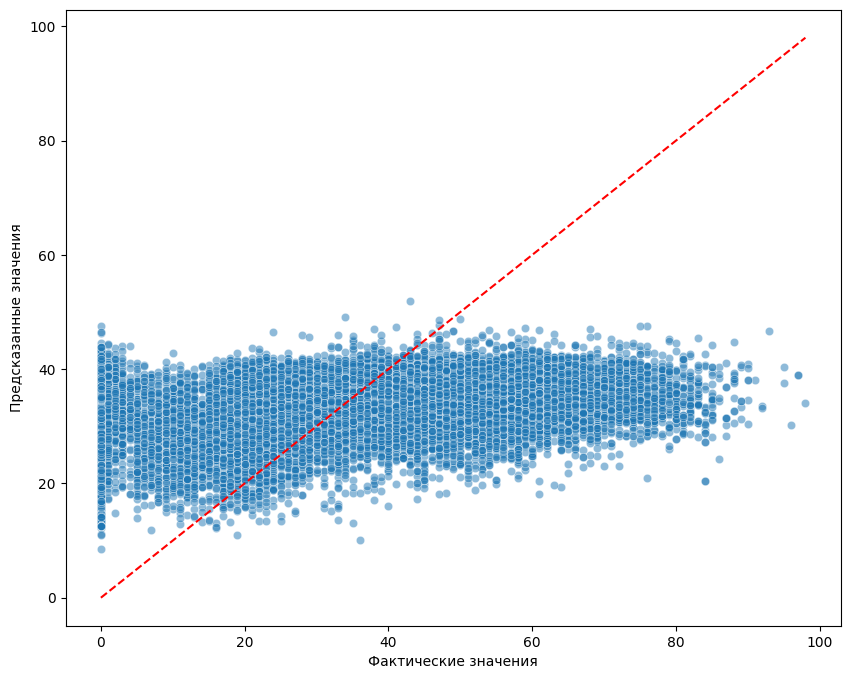

In [17]:
rf_run = runs[runs['tags.mlflow.runName'] == 'GradientBoosting'].iloc[0]
rf_model = mlflow.sklearn.load_model(f"runs:/{rf_run.run_id}/model")
rf_predictions = rf_model.predict(X_val)
y_val_actual = scaler.inverse_transform(y_val)#Инвертируем в исходный вид
y_val_pred = scaler.inverse_transform(rf_predictions.reshape(-1, 1))

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_val_actual.flatten(), y=y_val_pred.flatten(), alpha=0.5)#По оси х-реальное, по y-предсказанное
plt.plot([y_val_actual.min(), y_val_actual.max()], [y_val_actual.min(), y_val_actual.max()], 'r', linestyle='--')#Если точки на этой линии, значит угадали
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.show()

## Выводы, лучшая модель

По всем метрикам среди обученных моделей лучше всего справлась RandomForest.
По графикам видно, что это модель лучше всего(среди обученных) угадывает популярность песни. Все остальные модели предсказывают какое-то среднее значение (около 30)
Случайный лес же хоть как-то предсказывает популярность песен, приближаясь к фактическим значениям.
Метрики моделей можно улучшить, проведя работу над датасетом (новые фичи, удаление ненужных)
Скорее всего ридж и лассо показали плохие результаты из-за отсутствия линейной зависимости между таргетом и фичами. А лес способен обрабатывать не только фичи по отдельности, но и связи между фичами + он более устойчив к выбросам, т.к каждое дерево строится на случайных фичах